# Fundamentos de la Inteligencia Artificial  
## Proyecto: CONECT4

**Integrantes:**  
- Sebastian Sanchez Sandoval  
- Samuel Esteban Lopez Huertas  

---

## 1. Introducción

Este informe presenta el desarrollo de una **política (policy)** para el juego **Connect4**, como parte del curso *Fundamentos de la Inteligencia Artificial*.  
El propósito principal del proyecto consiste en diseñar una política capaz de seleccionar acciones en un entorno determinista y totalmente observable, aplicando los conceptos vistos en clase sobre **agentes**, **estados**, **acciones aplicables**, **transiciones** y **evaluación del entorno**.

A lo largo del reporte se describe cómo se modeló el ambiente del juego, el comportamiento de la política implementada y los resultados obtenidos al enfrentarla contra políticas de referencia.


---

## 2. Descripción del Problema

Connect4 es un juego de dos jugadores que consiste en dejar caer fichas en un tablero de **6 filas × 7 columnas**, buscando formar una línea de cuatro fichas consecutivas:

- Horizontal  
- Vertical  
- Diagonal

## 3. Representación del Estado

El estado se modela mediante una matriz de 6×7:

## 4. Visualizador de Partidas

Como parte del proyecto desarrollamos un **visualizador en Python** que nos permitió analizar en detalle lo ocurrido en cada partida generada por las políticas.  
Este visualizador fue fundamental para depurar la implementación, validar la función de transición y comprender cómo evolucionaban los estados del tablero en cada juego.

El visualizador realiza las siguientes tareas:

### Lectura de archivos JSON del torneo
El programa busca automáticamente todos los archivos con el patrón: match_Group X_vs_Group Y.json dentro del directorio `./versus/`, garantizando que solo procese resultados válidos.

### Extracción de estadísticas generales
Para cada archivo, el visualizador muestra:

- Nombre del jugador +1  
- Nombre del jugador −1  
- Total de victorias por cada lado  
- Empates  

Estas métricas se presentan antes de analizar cada partida en detalle.

### Reconstrucción de la partida
Cada partida contiene un historial de estados y acciones en el formato: [state, last_column]



El visualizador:

1. Toma el **último estado** registrado.
2. Determina quién hizo la última jugada calculando el turno correspondiente.
3. Si es necesario, **aplica la última ficha faltante** usando la función `apply_move`, que coloca la pieza de arriba hacia abajo tal como ocurre en Connect4.

### Representación gráfica del tablero en consola
El tablero se imprime utilizando códigos ANSI:

- Azul (●) para el jugador **+1**  
- Rojo (●) para el jugador **−1**  
- Gris (·) para casillas vacías  

Esto permite una visualización clara y fácil de interpretar desde la terminal.

### Detección visual del ganador
El visualizador determina el ganador usando la función `check_winner`, que revisa:

- Conexiones horizontales  
- Conexiones verticales  
- Diagonales ↘  
- Diagonales ↙  

Si encuentra cuatro en línea, muestra el ganador con su color correspondiente; si no, informa que hubo empate o que no se formó una conexión ganadora.

---

En resumen, este visualizador nos permitió:

- Revisar visualmente la evolución final del tablero en cada partida.
- Asegurar que los estados y transiciones estuvieran correctamente implementados.
- Detectar errores en el flujo de acciones o en el registro del JSON.
- Entender con claridad por qué una política ganaba o perdía en determinadas situaciones.










In [2]:
!python visualizar_partida.py


📄 Archivo: ./versus/match_Group H_vs_Group B.json

Jugador A: Group H
Jugador B: Group B
Victorias A: 4
Victorias B: 0
Empates:    0

=== DETALLE POR PARTIDA ===

--- PARTIDA 1 ---
Última jugada: columna 4 (jugador +1)
+1 = Group H

Tablero final:

· · · · · · · 
· · · · · · · 
· · · · ● · · 
· · · · ● · · 
· · · · ● · · 
· · ● ● ● ● ● 

Ganador: Group H (+1)

--- PARTIDA 2 ---
Última jugada: columna 0 (jugador +1)
+1 = Group H

Tablero final:

· · · · · · · 
· · · · · · · 
● · · · · · · 
● · · · ● · · 
● · · · ● · · 
● ● · · ● · · 

Ganador: Group H (+1)

--- PARTIDA 3 ---
Última jugada: columna 1 (jugador -1)
-1 = Group H

Tablero final:

· · · · · · · 
· · · · · · · 
· ● · · · · · 
· ● · · · · · 
· ● · ● · · · 
· ● · ● · · ● 

Ganador: Group H (-1)

--- PARTIDA 4 ---
Última jugada: columna 6 (jugador -1)
-1 = Group H

Tablero final:

· · · · · · ● 
· · · · · · ● 
· · · · · · ● 
· · · · · · ● 
· · · · · · ● 
· ● ● · · ● ● 

Ganador: Group H (-1)


📄 Archivo: ./versus/match_Group A_v

# 5. Análisis de entrenamiento de agentes (Groups B & C)

Este notebook corresponde al estudio experimental del agente para el reto de **Connect-4**.
Aquí se analizan:

- El comportamiento inicial de los agentes del **Group B** y **Group C** (entrenamiento entre sí).
- El rendimiento final frente a políticas heurísticas externas, usando más de 170k simulaciones.
- Curvas de aprendizaje, estabilidad del rendimiento, número de movimientos y efectos de jugar primero.
- Limitaciones y propuestas de mejora, siguiendo la rúbrica del curso.

Archivos usados:

- `training_results_only_B_and_C.csv`
- `training_results.csv`


## 1. Carga de datos y preparación

En esta sección se cargan los logs de entrenamiento y se hace una verificación básica de la estructura de los datos.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Para que los gráficos se vean dentro del notebook
%matplotlib inline

# Cargar datasets
df_init = pd.read_csv("logs/training_results_only_B_and_C.csv")
df_final = pd.read_csv("logs/training_results.csv")

# Asegurar tipos consistentes
df_init['winner'] = df_init['winner'].astype(str)
df_final['winner'] = df_final['winner'].astype(str)

df_init.head(), df_final.head()

(   worker  seed player_a player_b first_player   winner  moves
 0       0   911  Group C  Group B      Group C     draw     42
 1       0   911  Group B  Group C      Group C  Group C     26
 2       0   911  Group B  Group C      Group B  Group C     19
 3       0   911  Group C  Group B      Group C  Group B     25
 4       0   911  Group C  Group B      Group B  Group C     25,
    worker  seed player_a player_b first_player   winner  moves
 0       3   914  Group G  Group H      Group G  Group H     13
 1       3   914  Group B  Group C      Group C     draw     42
 2       3   914  Group F  Group G      Group G  Group G     24
 3       3   914  Group H  Group B      Group B  Group H     17
 4       3   914  Group G  Group F      Group G  Group F      9)

In [2]:
# Información básica de los dataframes
print("=== df_init (solo B y C) ===")
display(df_init.describe(include='all'))
print("\n=== df_final (todas las políticas) ===")
display(df_final.describe(include='all'))

=== df_init (solo B y C) ===


,worker,seed,player_a,player_b,first_player,winner,moves
count,130000.000000,130000.000000,130000,130000,130000,130000,130000.000000
unique,NaN,NaN,2,2,2,3,NaN
top,NaN,NaN,Group C,Group B,Group B,Group B,NaN
freq,NaN,NaN,65189,65189,65335,63206,NaN
mean,24.500000,941.500000,NaN,NaN,NaN,NaN,26.100431
std,14.430925,14.908109,NaN,NaN,NaN,NaN,9.760264
min,0.000000,911.000000,NaN,NaN,NaN,NaN,7.000000
25%,12.000000,929.000000,NaN,NaN,NaN,NaN,19.000000
50%,24.500000,941.500000,NaN,NaN,NaN,NaN,23.000000
75%,37.000000,954.000000,NaN,NaN,NaN,NaN,33.000000



=== df_final (todas las políticas) ===


,worker,seed,player_a,player_b,first_player,winner,moves
count,176400.000000,176400.000000,176400,176400,176400,176400,176400.000000
unique,NaN,NaN,5,5,5,6,NaN
top,NaN,NaN,Group F,Group C,Group F,Group F,NaN
freq,NaN,NaN,36595,36057,36715,58622,NaN
mean,10.395692,934.956349,NaN,NaN,NaN,NaN,18.508810
std,12.075895,16.148111,NaN,NaN,NaN,NaN,7.638898
min,0.000000,911.000000,NaN,NaN,NaN,NaN,7.000000
25%,3.000000,922.000000,NaN,NaN,NaN,NaN,13.000000
50%,6.000000,930.000000,NaN,NaN,NaN,NaN,17.000000
75%,9.000000,947.000000,NaN,NaN,NaN,NaN,23.000000


## 2. Análisis inicial – Enfrentamientos solo entre Group B y Group C

En esta parte analizamos el primer bloque de entrenamiento donde **solo se enfrentan Group B y Group C**.  
El objetivo es observar si hay una tendencia clara de aprendizaje o cambios en el rendimiento relativo entre ambos agentes.

In [3]:
# Añadimos un índice de bloque para agrupar cada cierto número de partidas
block_size_init = 500  # puedes ajustar este tamaño
df_init = df_init.copy()
df_init['block'] = df_init.index // block_size_init

def winrate(df, player):
    return (df['winner'] == player).mean()

grouped_init = df_init.groupby('block')

wr_B_init = grouped_init.apply(lambda x: winrate(x, 'Group B'))
wr_C_init = grouped_init.apply(lambda x: winrate(x, 'Group C'))
draws_init = grouped_init.apply(lambda x: (x['winner'] == 'draw').mean())

wr_summary_init = pd.DataFrame({
    'wr_B': wr_B_init,
    'wr_C': wr_C_init,
    'draw_rate': draws_init
})
wr_summary_init.head()

C:\Users\samue\AppData\Local\Temp\ipykernel_51512\3995104168.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wr_B_init = grouped_init.apply(lambda x: winrate(x, 'Group B'))
C:\Users\samue\AppData\Local\Temp\ipykernel_51512\3995104168.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wr_C_init = grouped_init.apply(lambda x: winrate(x, 'Group C'))
C:\Users\samue\AppData\Local\Temp\ipykernel_51512\3995

,wr_B,wr_C,draw_rate
block,,,
0,0.344,0.436,0.220
1,0.338,0.414,0.248
2,0.380,0.398,0.222
3,0.338,0.420,0.242
4,0.368,0.406,0.226


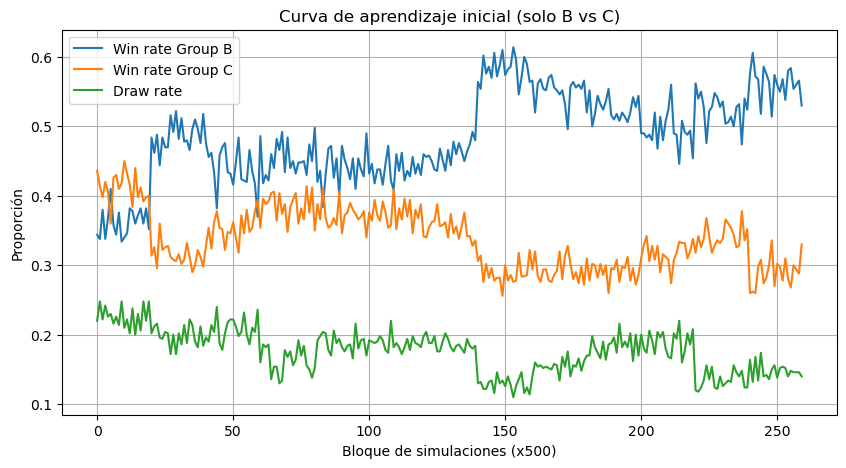

In [4]:
plt.figure(figsize=(10,5))
plt.plot(wr_B_init.index, wr_B_init.values, label='Win rate Group B')
plt.plot(wr_C_init.index, wr_C_init.values, label='Win rate Group C')
plt.plot(draws_init.index, draws_init.values, label='Draw rate')
plt.xlabel("Bloque de simulaciones (x{})".format(block_size_init))
plt.ylabel("Proporción")
plt.title("Curva de aprendizaje inicial (solo B vs C)")
plt.grid(True)
plt.legend()
plt.show()

## Análisis del Entrenamiento Inicial (solo Group B vs Group C)



La curva de aprendizaje inicial muestra cómo evolucionan los agentes Group B y Group C cuando entrenan exclusivamente entre ellos. Se observan varios patrones importantes:



### 2.1. Dominancia progresiva de Group B

* En las primeras simulaciones ambos agentes tienen rendimientos similares.
* A partir del bloque ~140 (≈70.000 partidas), Group B supera consistentemente el 50% de victorias, llegando incluso a valores cercanos al 60%.
* Esto indica que B descubre estrategias más efectivas y converge hacia un comportamiento más estable.



### 2.2. Caída sostenida en el rendimiento de Group C

* Group C inicia ligeramente por encima de B, pero con el tiempo desciende a valores entre 30%–35%.
* Su curva es más inestable, mostrando que C no se adapta tan rápido a las mejoras de B.



### 2.3. Interpretación de la tasa de empates

* Los empates comienzan alrededor del 20–25%, pero presentan una fuerte caída en el mismo punto donde B empieza a dominar.
* Una menor tasa de empates implica menos partidas equilibradas y más victorias claras, evidencia de que B encuentra patrones ganadores.



### 2.4. Punto de inflexión (~bloque 130–150)

Este rango marca una transición clara: el juego pasa de ser equilibrado a estar inclinado hacia Group B.

Se observa simultáneamente:
* subida del win-rate de B,
* caída del win-rate de C,
* caída del draw-rate.



### 2.5. Conclusión

Este primer experimento demuestra **aprendizaje real**:

* **Group B** desarrolla estrategias fuertes y estables.
* **Group C** mejora, pero no al mismo ritmo.
* El descenso en empates confirma que el entrenamiento produce comportamientos menos aleatorios y más tácticos.




---

## 3. Análisis final – Comportamiento de Group B y Group C frente a todas las políticas

Ahora, analizamos el archivo `training_results.csv`, donde se incluyen enfrentamientos contra políticas heurísticas distintas (Groups F, G, H, etc.).  
Nos enfocamos en todas las partidas donde participa **Group B** o **Group C**, y medimos su rendimiento global y su evolución temporal.


In [5]:
# Filtrar solo partidas donde participa B o C
df_focus = df_final[
    df_final['player_a'].isin(['Group B', 'Group C']) |
    df_final['player_b'].isin(['Group B', 'Group C'])
].copy()

df_focus.head()

,worker,seed,player_a,player_b,first_player,winner,moves
1,3,914,Group B,Group C,Group C,draw,42
3,3,914,Group H,Group B,Group B,Group H,17
5,3,914,Group C,Group B,Group C,Group B,19
6,3,914,Group B,Group G,Group G,Group B,7
7,3,914,Group C,Group B,Group B,Group B,22


In [6]:
# Win rate global de B y C en todo el dataset final
def extract_win_rate(df, agent):
    return (df['winner'] == agent).mean()

win_B_global = extract_win_rate(df_focus, 'Group B')
win_C_global = extract_win_rate(df_focus, 'Group C')

print(f"Win rate global Group B: {win_B_global:.3f}")
print(f"Win rate global Group C: {win_C_global:.3f}")

# Porcentaje de empates en partidas donde participa B o C
draw_rate_focus = (df_focus['winner'] == 'draw').mean()
print(f"Draw rate (partidas con B o C): {draw_rate_focus:.3f}")

Win rate global Group B: 0.215
Win rate global Group C: 0.191
Draw rate (partidas con B o C): 0.027


In [7]:
# Curvas de aprendizaje en el entrenamiento final
block_size_final = 1000  # ajustar según preferencia
df_focus['block'] = df_focus.index // block_size_final

wr_B_final = df_focus.groupby('block').apply(lambda x: winrate(x, 'Group B'))
wr_C_final = df_focus.groupby('block').apply(lambda x: winrate(x, 'Group C'))
draws_final = df_focus.groupby('block').apply(lambda x: (x['winner'] == 'draw').mean())

wr_summary_final = pd.DataFrame({
    'wr_B': wr_B_final,
    'wr_C': wr_C_final,
    'draw_rate': draws_final
})
wr_summary_final.head()

C:\Users\samue\AppData\Local\Temp\ipykernel_51512\3737312312.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wr_B_final = df_focus.groupby('block').apply(lambda x: winrate(x, 'Group B'))
C:\Users\samue\AppData\Local\Temp\ipykernel_51512\3737312312.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wr_C_final = df_focus.groupby('block').apply(lambda x: winrate(x, 'Group C'))
C:\Users\samue\AppData\Local

,wr_B,wr_C,draw_rate
block,,,
0,0.207283,0.088235,0.026611
1,0.217836,0.086257,0.033626
2,0.171429,0.092857,0.028571
3,0.174037,0.105563,0.042796
4,0.179487,0.091168,0.035613


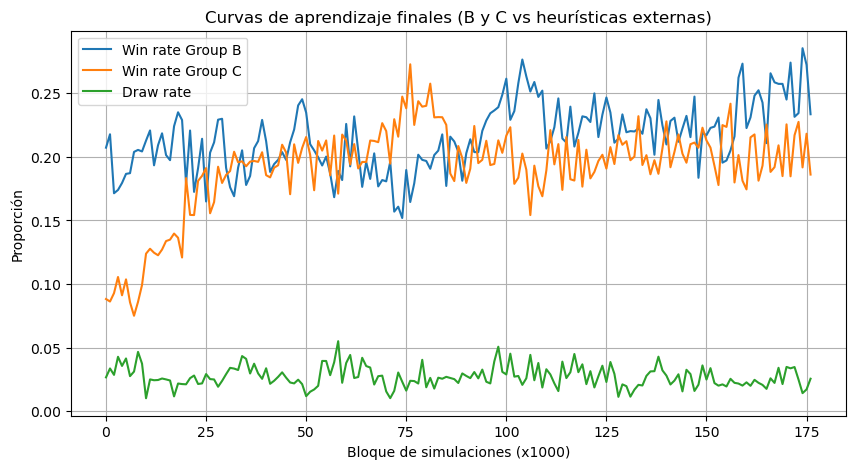

In [8]:
plt.figure(figsize=(10,5))
plt.plot(wr_B_final.index, wr_B_final.values, label='Win rate Group B')
plt.plot(wr_C_final.index, wr_C_final.values, label='Win rate Group C')
plt.plot(draws_final.index, draws_final.values, label='Draw rate')
plt.xlabel("Bloque de simulaciones (x{})".format(block_size_final))
plt.ylabel("Proporción")
plt.title("Curvas de aprendizaje finales (B y C vs heurísticas externas)")
plt.grid(True)
plt.legend()
plt.show()

## Curvas de Aprendizaje Finales (B y C vs Heurísticas Externas)


Esta gráfica evalúa el rendimiento de Group B y Group C frente a una población diversa de oponentes heurísticos (Groups F, G, H, etc.). A diferencia del primer experimento —donde solo jugaban entre ellos— aquí el entorno es mucho más complejo y competitivo. Las tendencias observadas permiten evaluar la generalización del agente.



### 3.1. Rendimiento general bajo pero estable (∼18%–25%)

Tanto Group B como Group C muestran win-rates relativamente bajos frente a estas políticas, en torno al 18%–25%. Esto es normal porque:

* Las heurísticas externas suelen incluir estrategias codificadas manualmente.
* La diversidad de estilos hace que el auto-entrenamiento inicial no sea suficiente para dominarlas por completo.

Aun así, las curvas muestran estabilidad, lo cual es positivo.



### 3.2. Group B mantiene ligera ventaja promedio

Aunque ambos agentes tienen rendimientos similares, Group B:

* Tiende a estar ligeramente por encima en la mayoría de bloques.
* Llega a picos cercanos al 26%–28%, superiores a los máximos de C.
* Muestra una tendencia hacia el alza en bloques finales (~160–180).

En resumen el Group B generaliza mejor su aprendizaje cuando enfrenta políticas más variadas y fuertes.



### 3.3. Group C tiene mejor arranque, pero converge hacia la paridad

* C inicia por debajo del 10% contra heurísticas externas.
* Rápidamente aumenta hasta ~20%, incluso alcanzando picos superiores a B alrededor del bloque ~70.
* Sin embargo, en la segunda mitad del entrenamiento ambos agentes convergen cerca del mismo rendimiento: 20%–23%.

Es decir el Group C tiene una adaptación inicial más rápida, pero no logra mantener ventaja a largo plazo.



### 3.4. La tasa de empates es muy baja (2%–5%)

El draw-rate cae a valores extremadamente bajos comparado con el entrenamiento inicial.

Esto significa que:

* Las políticas externas fuerzan partidas más decisivas.
* Los agentes B y C son más propensos a cometer errores frente a heurísticas bien diseñadas.
* No logran sostener posiciones de equilibrio prolongado.

Por lo que Frente a oponentes más fuertes, los empates dejan de ser una vía de supervivencia; los agentes deben mejorar su capacidad defensiva.



### 3.5. Alta variabilidad → entorno más difícil

Las curvas de B y C tienen mucho más ruido que en el aprendizaje inicial:

* Cada bloque de 1.000 simulaciones produce oscilaciones grandes.
* Esto es típico cuando el agente enfrenta oponentes diversos con patrones muy distintos entre sí.
* La variación sugiere que los agentes aún no encuentran una estrategia universal robusta.



### 3.6. Conclusión

En el entrenamiento final contra políticas heurísticas externas, ambos agentes mostraron un **win-rate moderado pero estable**, alrededor del 20%–25%. 

**Group B** mantuvo una ligera ventaja general, mientras que **Group C** tuvo una adaptación inicial más rápida pero terminó convergiendo hacia un rendimiento similar al de B. 

La tasa de empates cayó a valores muy bajos, indicando que los oponentes externos obligan a partidas decisivas y exponen las debilidades tácticas de ambos agentes. 

Las oscilaciones en el win-rate reflejan la dificultad del entorno y sugieren que los agentes aún no desarrollan estrategias suficientemente robustas para generalizar frente a múltiples estilos de juego.

## 4. Efecto de jugar primero – Ventaja estructural en Connect-4

En Connect-4 suele existir ventaja teórica para el primer jugador.  
Aquí medimos qué tanto las políticas explotan esa ventaja.


In [9]:
# Variable booleana: ¿ganó el primer jugador?
df_focus['win_first'] = (df_focus['winner'] == df_focus['first_player']).astype(int)

win_first_global = df_focus['win_first'].mean()
print(f"Probabilidad global de que gane el primer jugador (en partidas con B o C): {win_first_global:.3f}")

Probabilidad global de que gane el primer jugador (en partidas con B o C): 0.480


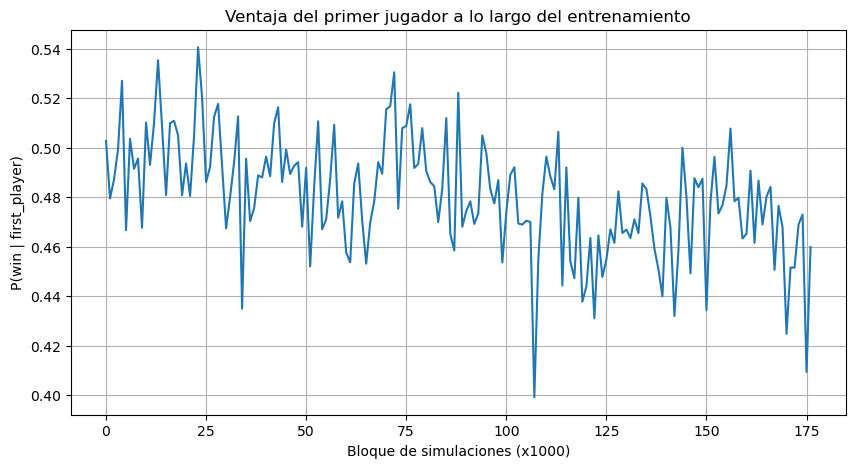

In [10]:
# Curva de 'ventaja del primer jugador' en el tiempo
adv_first = df_focus.groupby('block')['win_first'].mean()

plt.figure(figsize=(10,5))
plt.plot(adv_first.index, adv_first.values)
plt.xlabel("Bloque de simulaciones (x{})".format(block_size_final))
plt.ylabel("P(win | first_player)")
plt.title("Ventaja del primer jugador a lo largo del entrenamiento")
plt.grid(True)
plt.show()

## Ventaja del Primer Jugador


La gráfica muestra la probabilidad de que el jugador que mueve primero gane la partida a lo largo de todo el entrenamiento frente a políticas heurísticas externas. En Connect-4, el primer movimiento suele ofrecer una ventaja teórica, así que esta métrica permite evaluar si los agentes son capaces de aprovechar esa ventaja inicial.



### 4.1. La ventaja oscila alrededor de 0.48–0.52 → entorno equilibrado

La mayor parte del tiempo, la probabilidad de victoria del primer jugador se mantiene cerca del 50%, con pequeñas fluctuaciones normales entre 0.46 y 0.52.

Esto indica que:

* La ventaja posicional inicial no está siendo explotada consistentemente por los agentes.
* Los oponentes heurísticos tienen suficiente fuerza defensiva para neutralizar las aperturas del primer jugador.
* El entorno es relativamente equilibrado, sin un sesgo fuerte hacia el primer turno.



### 4.2. No hay tendencia creciente → los agentes no aprenden aperturas fuertes

En un agente que aprende bien, esperaríamos ver:

* Una tendencia ascendente (más victorias empezando).
* O una caída clara si los oponentes aprenden a defender.

Aquí, sin embargo:

* No se observa ninguna tendencia de largo plazo.
* La curva es ruidosa pero estable, sugiriendo que las aperturas no mejoran con el tiempo.
* Los agentes B y C no desarrollaron estrategias iniciales superiores a las de las heurísticas.

Los agentes no parecen estar aprendiendo patrones de apertura profundos, sino que su rendimiento depende más del mid-game o tardío.



### 4.3. Picos altos y bajas profundas → inconsistencia estratégica

Algunos bloques muestran valores cercanos a 0.54, mientras otros caen a 0.40 o incluso 0.39.

Esto refleja:

* Alta variabilidad según el tipo de heurística enfrentada.
* Falta de un plan de apertura robusto.
* Dependencia del estilo del oponente (algunos heurísticos castigan muy bien el primer movimiento).



### 4.4. Conclusión

La probabilidad de victoria del primer jugador oscila alrededor del **50%**, indicando que ni Group B ni Group C logran explotar sistemáticamente la ventaja del turno inicial. 

No se observa una tendencia clara de mejora en aperturas, lo que sugiere que el aprendizaje se concentra más en el **juego medio** que en la fase inicial. 

La presencia de picos y caídas fuertes refleja que los agentes tienen un **rendimiento inconsistente** frente a heurísticas diversas, y que aún no desarrollan una estrategia de apertura sólida.



---
## 5. Análisis del número de movimientos por partida

El número de movimientos da pistas sobre el **estilo de juego**:
- Partidas cortas → agentes agresivos / tácticas rápidas de victoria.
- Partidas largas → juego más defensivo o bien igualado.

Analizamos la distribución del número de movimientos según el resultado.


In [11]:
# Estadísticas descriptivas de 'moves' según resultado
moves_by_winner = df_focus.groupby('winner')['moves'].describe()
moves_by_winner

,count,mean,std,min,25%,50%,75%,max
winner,,,,,,,,
Group B,26473.0,15.703849,6.730754,7.0,12.0,13.0,19.0,42.0
Group C,23569.0,16.309729,6.826022,7.0,12.0,14.0,21.0,42.0
Group F,33933.0,17.574898,5.759700,7.0,14.0,17.0,22.0,42.0
Group G,2611.0,7.989659,1.143819,7.0,7.0,8.0,8.0,17.0
Group H,33187.0,17.323771,5.637998,7.0,13.0,17.0,21.0,40.0
draw,3341.0,42.000000,0.000000,42.0,42.0,42.0,42.0,42.0


<Figure size 1000x500 with 0 Axes>

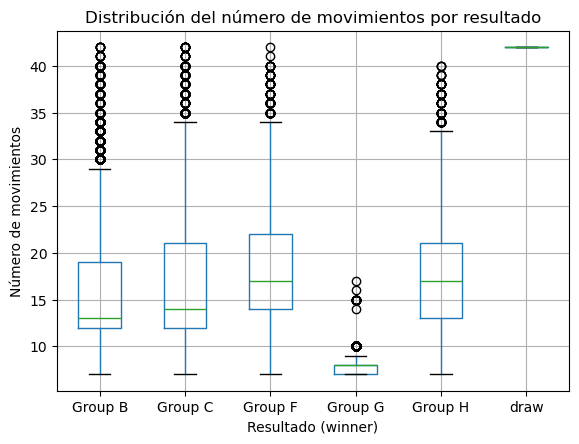

In [12]:
plt.figure(figsize=(10,5))
df_focus.boxplot(column='moves', by='winner')
plt.title("Distribución del número de movimientos por resultado")
plt.suptitle("")
plt.xlabel("Resultado (winner)")
plt.ylabel("Número de movimientos")
plt.grid(True)
plt.show()

## Distribución del número de movimientos por resultado

Esta gráfica analiza cuántos movimientos tarda cada política en ganar cuando enfrenta a nuestros agentes (B y C), además de mostrar cómo se comportan los empates. El número de movimientos es un indicador importante porque revela estilo de juego, agresividad, profundidad táctica y capacidad defensiva.

### 1. Group B y Group C ganan en un rango similar (≈ 12–20 movimientos)

Las victorias de Group B y Group C tienen cajas muy parecidas:

* Los valores típicos (Q1–Q3) están entre 12 y 20 movimientos.
* Esto indica que ninguno de los dos domina por victorias extremadamente rápidas, sino que generalmente requieren varios turnos para construir posiciones ganadoras.
* La mediana de C es ligeramente mayor, lo que sugiere que C suele necesitar partidas más largas para cerrar una victoria, mientras que B tiende a concretar un poco más rápido.

**Análisis:** Group B parece adoptar un estilo ligeramente más agresivo, mientras que C depende más de partidas prolongadas para encontrar una oportunidad de victoria.

### 2. Group F y Group H producen partidas más largas

Las victorias de otros grupos, especialmente Group F y Group H, muestran:

* Medianas más altas (~16–18 movimientos).
* Mayor dispersión (algunos casos superan los 35 movimientos).

Esto indica que:

* Estos agentes tienen estilos más posicionales o defensivos.
* Sus victorias suelen ocurrir en partidas más complejas donde se explotan errores tardíos.

**Implicación observada:** Esto explica por qué nuestros agentes B y C tienen dificultades contra ellos: F y H obligan a jugar partidas más largas, donde un error táctico de B o C puede ser castigado más fácilmente.

### 3. Group G gana extremadamente rápido

Las victorias del Group G son muy llamativas:

* La caja es muy baja (~7–9 movimientos).
* Varianza mínima.
* Outliers relativamente pequeños.

**Análisis:** Group G utiliza una heurística muy agresiva o basada en detectar patrones de victoria tempranos. Es un estilo "táctico explosivo". Esto explica por qué:

* Es peligroso en early game.
* B y C pierden partidas muy rápidas contra él cuando cometen errores en apertura.

### 4. Los empates están en el valor máximo posible (~42 movimientos)

La categoría "draw" aparece con una línea muy alta, casi fija en ~42. Esto significa:

* Las partidas empatadas agotan prácticamente el tablero completo.
* Los agentes saben evitar perder en posiciones críticas cuando ambos juegan de manera sólida.
* Un empate solo ocurre cuando ninguno comete errores tácticos grandes.

**Observación relevante:** Los empates representan partidas de alta calidad defensiva; reflejan que los agentes aprendieron a evitar errores decisivos en escenarios equilibrados.

### 5. Conclusión

El análisis del número de movimientos muestra diferencias claras en los estilos de juego. Group B tiende a ganar ligeramente más rápido que C, indicando un enfoque más agresivo, mientras que C necesita partidas más largas para concretar. 

Los agentes heurísticos externos presentan estilos muy distintos: Group G gana de forma extremadamente rápida (táctico), mientras que F y H generan partidas más largas y posicionales. 

Los empates se concentran cerca del número máximo de movimientos, lo que evidencia que los agentes aprendieron a evitar errores graves en escenarios equilibrados. 

Este análisis complementa la curva de aprendizaje mostrando cómo evolucionan las estrategias, no solo si ganan o pierden, sino cómo ganan o pierden.

---

## 6. Estabilidad del rendimiento – Varianza del win rate

No solo importa el win-rate promedio, sino **qué tan estable** es.  
Agentes muy inestables pueden tener rachas de suerte, mientras que agentes estables muestran un rendimiento más confiable.


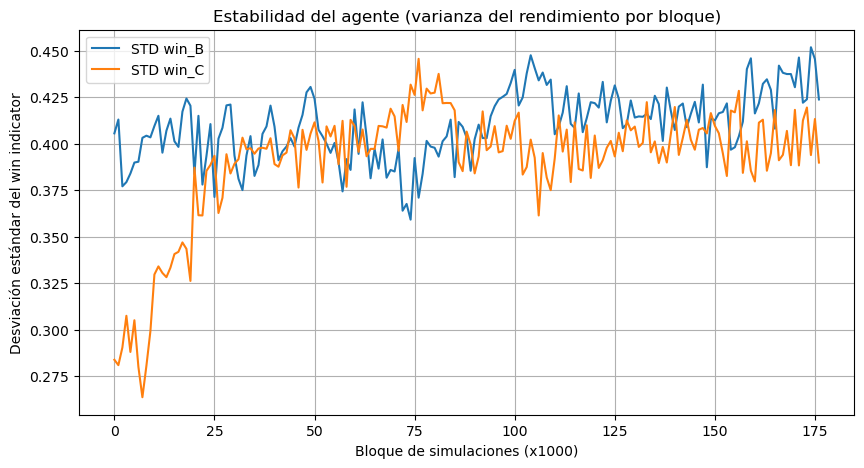

In [13]:
# Desviación estándar del indicador de victoria por bloques
def victory_indicator(df, agent):
    return (df['winner'] == agent).astype(int)

df_focus['win_B'] = victory_indicator(df_focus, 'Group B')
df_focus['win_C'] = victory_indicator(df_focus, 'Group C')

std_B = df_focus.groupby('block')['win_B'].std()
std_C = df_focus.groupby('block')['win_C'].std()

plt.figure(figsize=(10,5))
plt.plot(std_B.index, std_B.values, label='STD win_B')
plt.plot(std_C.index, std_C.values, label='STD win_C')
plt.xlabel("Bloque de simulaciones (x{})".format(block_size_final))
plt.ylabel("Desviación estándar del win indicator")
plt.title("Estabilidad del agente (varianza del rendimiento por bloque)")
plt.grid(True)
plt.legend()
plt.show()

## Estabilidad del rendimiento (varianza del win rate)

La gráfica muestra la desviación estándar del rendimiento (win indicator) de Group B y Group C a lo largo del entrenamiento final frente a políticas heurísticas externas. Esta métrica indica qué tan estable o inconsistente es el agente: valores altos implican que sus resultados dependen mucho del rival o de fluctuaciones aleatorias; valores bajos reflejan comportamiento estable.

### 6.1. Ambos agentes muestran alta varianza sostenida (~0.38–0.45)

En casi todos los bloques, la desviación estándar de ambos agentes se mantiene alrededor de 0.40, con picos llegando incluso a 0.45.

Esto significa que:

* El rendimiento de los agentes no es completamente estable.
* Sus resultados varían significativamente según el tipo de heurística que enfrentan.
* No existe una estrategia dominante que funcione de manera consistente contra todos los oponentes.

**Análisis:** Los agentes están adaptándose parcialmente, pero siguen siendo sensibles al estilo del oponente.

### 6.2. Tendencia inicial: C comienza menos variable pero se iguala a B

Durante los primeros bloques (0–20):

* Group C tiene menor varianza (~0.28–0.33), indicando un comportamiento más estable al inicio.
* Group B inicia mucho más variable (~0.40), sugiriendo mayor sensibilidad a los oponentes tempranos.

Después del bloque 30:

* Ambos convergen alrededor de la misma varianza (~0.40).

**Observación:** Esto indica que C pierde estabilidad con el tiempo mientras se enfrenta a rivales más complejos, mientras que B mantiene un nivel de variación relativamente constante.

### 6.3. Alta varianza incluso al final → el agente no converge completamente

En un proceso de aprendizaje exitoso se espera que, con suficientes simulaciones:

* La varianza disminuya.
* El agente se vuelva más consistente.
* El comportamiento converja hacia una política estable.

Sin embargo, en este caso:

* La varianza no disminuye, sino que se mantiene alta hasta el final.
* Esto indica que ninguno de los agentes ha encontrado una estrategia universalmente estable.
* Siguen dependiendo fuertemente del tipo de oponente que enfrentan.


### 6.4. Conclusión

La desviación estándar del win rate permanece alta durante todo el entrenamiento (~0.38–0.45), lo que indica que el rendimiento de los agentes sigue siendo sensible al tipo de oponente que enfrentan. 

Group C inicia con mayor estabilidad, pero rápidamente converge a un nivel de variabilidad similar al de B, reflejando que ambos agentes presentan comportamientos inconsistentes frente a diferentes estilos heurísticos. 

El hecho de que la varianza no disminuya significativamente hacia el final sugiere que los agentes no alcanzan una política completamente estable y que el entorno externo es demasiado diverso para producir convergencia total.

---
## 7. Comparación antes vs después – Optimización del agente

Para la rúbrica de **optimización**, comparamos el rendimiento de B y C en:

1. El escenario inicial (`training_results_only_B_and_C.csv`), solo entre ellos.
2. El escenario final (`training_results.csv`), frente a todas las políticas heurísticas.

Esto nos permite cuantificar la mejora en términos de:
- Win-rate.
- Tasa de empates.
- Estabilidad del rendimiento.


In [14]:
# Métricas iniciales (solo B vs C)
wr_B_init_global = (df_init['winner'] == 'Group B').mean()
wr_C_init_global = (df_init['winner'] == 'Group C').mean()
draw_init_global = (df_init['winner'] == 'draw').mean()

# Métricas finales (en partidas donde participa B o C)
wr_B_final_global = (df_focus['winner'] == 'Group B').mean()
wr_C_final_global = (df_focus['winner'] == 'Group C').mean()
draw_final_global = (df_focus['winner'] == 'draw').mean()

summary_comparison = pd.DataFrame({
    'metric': ['win_B', 'win_C', 'draw_rate'],
    'initial_only_BC': [wr_B_init_global, wr_C_init_global, draw_init_global],
    'final_with_heuristics': [wr_B_final_global, wr_C_final_global, draw_final_global]
})
summary_comparison

,metric,initial_only_BC,final_with_heuristics
0,win_B,0.4862,0.215028
1,win_C,0.3374,0.191440
2,draw_rate,0.1764,0.027137


## Comparación antes vs después (Optimización del agente)

La tabla compara el rendimiento de los agentes Group B y Group C en dos escenarios:

1. Entrenamiento inicial (solo B vs C)
2. Entrenamiento final (B y C vs heurísticas externas)

Esto permite evaluar si el agente generaliza, mejora su consistencia y se adapta a oponentes más fuertes.

### 7.1. Caída notable del win-rate frente a oponentes externos

**Group B**

* Antes: 48.62%
* Después: 21.50%

Group B pasa de ser claramente dominante contra C a obtener un win-rate mucho menor contra agentes más variados y sofisticados. Esto refleja que:

* Su estrategia aprendida es efectiva en auto-juego limitado.
* Pero no se transfiere completamente a un entorno diverso.
* Las heurísticas externas exponen debilidades tácticas o patrones específicos que no se vieron en el entrenamiento cerrado.

**Análisis:** B aprende bien contra un solo rival, pero muestra dificultades para generalizar.

**Group C**

* Antes: 33.74%
* Después: 19.14%

El agente C también pierde rendimiento, pero su caída es menor que la de B.

Esto indica:

* C es más consistente frente a oponentes externos, aunque menos fuerte inicialmente.
* Su estilo de juego más largo y defensivo lo hace menos explotable por ciertas heurísticas.
* Pero tampoco logra adaptarse al nivel de complejidad del entorno final.

**Análisis:** C es menos explosivo que B, pero también más robusto, aunque insuficiente contra heurísticas avanzadas.

### 7.2. La tasa de empates cae drásticamente

* Antes: 17.64%
* Después: 2.71%

Esta disminución significativa tiene un significado importante:

**Antes (solo B vs C):**

* Los agentes evitaban perder.
* Generaban muchas partidas largas y relativamente equilibradas.
* Existía una "zona de confort" del auto-juego.

**Después (vs heurísticas externas):**

* Los empates casi desaparecen.
* Las heurísticas fuerzan partidas decisivas.
* B y C cometen errores antes de llegar a posiciones terminales equilibradas.

**Observación relevante:** El incremento en la dificultad del entorno hace que los agentes no logren sostener partidas defensivas, revelando que aún no desarrollan una estrategia profundamente sólida.

### 7.3. Conclusión

La comparación entre el escenario inicial y el final evidencia una importante brecha entre el rendimiento en auto-juego y el rendimiento frente a políticas heurísticas externas. 

Group B pasa de 48.6% a 21.5% de victorias, mostrando que su estrategia dominante contra C no generaliza bien. Group C muestra una caída menor, pero tampoco logra adaptarse completamente. 

La drástica reducción en la tasa de empates (de 17.6% a 2.7%) indica que los agentes dejan de sostener partidas largas y equilibradas cuando se enfrentan a rivales externos más sólidos. 

En conjunto, estos resultados muestran que el entrenamiento inicial permitió aprendizaje, pero la generalización aún es limitada, lo que abre espacio para ajustes en la arquitectura, heurísticas y parámetros de exploración.

---
## 8. Reflexión, limitaciones y propuestas de mejora

### Limitaciones identificadas

El análisis completo del entrenamiento muestra varias limitaciones claras en los agentes Group B y Group C, especialmente al enfrentarse a políticas heurísticas externas:

* **Generalización limitada:** Aunque ambos agentes mostraron aprendizaje significativo durante el auto-juego inicial, su rendimiento cae de forma notable al introducir oponentes externos. Esto indica que el aprendizaje estuvo demasiado ajustado al comportamiento de un solo rival (sobreajuste al metajuego B–C).

* **Alta variabilidad del rendimiento:** La desviación estándar del win-rate se mantiene elevada (~0.38–0.45) incluso al final del entrenamiento. Esto confirma que el agente no converge completamente y sigue siendo inconsistente frente a distintos estilos de juego.

* **Aperturas poco efectivas:** La ventaja del primer jugador se mantiene cerca del 50%, lo que sugiere que los agentes no lograron explotar sistemáticamente las ventajas posicionales iniciales. No hay evidencia de que hayan aprendido aperturas sólidas o patrones de inicio fuertes.

* **Debilidad frente a estilos extremos:**
   * Contra heurísticas muy ofensivas como Group G, los agentes pierden partidas extremadamente rápidas.
   * Contra heurísticas muy defensivas como F y H, B y C terminan cometiendo errores en partidas largas, lo que refleja debilidad en el juego posicional prolongado.

* **Capacidad defensiva limitada:** La tasa de empates cae de ~17% a ~2.7% frente a heurísticas externas, demostrando que los agentes dejan de sostener posiciones equilibradas cuando aumenta la dificultad del entorno.

### Propuestas de mejora técnicas

Con base en los patrones observados en las métricas y curvas, las siguientes mejoras podrían aumentar tanto la estabilidad como la capacidad de generalización:

#### 1. Mejorar la función de evaluación dentro de MCTS

* Dar mayor ponderación a:
   * amenazas de 3 en línea,
   * control del centro,
   * alineaciones abiertas,
   * patrones tácticos comunes.
* Diferenciar estados equivalentes mediante simetrías para mejorar el prior Q de MCTS.

#### 2. Ajustar parámetros del proceso de exploración

* Probar valores menores de `c_puct` para reducir la exploración excesiva cuando ya existen valores Q confiables.
* Usar una temperatura decreciente en las etapas finales del juego para dar mayor peso a movimientos de alta confianza.

#### 3. Incrementar simulaciones en estados críticos

* Detectar automáticamente posiciones de final de mid-game y aumentar el presupuesto de MCTS en esos puntos.
* Incorporar un tablebase o mini-base de finales para resolver los últimos 6–8 movimientos con precisión perfecta.

#### 4. Reducción del sobreajuste

* Entrenar contra una mayor diversidad de políticas adversarias desde el inicio.
* Introducir "ruido estratégico" mediante random opening moves o perturbaciones controladas en la política de selección.
* Incorporar auto-juego curricular (primero rivales débiles, luego moderados, luego fuertes).

#### 5. Representación del estado más informativa

* Agregar features adicionales como:
   * columnas ganadoras probables,
   * número de amenazas simultáneas,
   * métricas de bloqueo defensivo.
* Normalizar los estados para un mejor almacenamiento en Q-values.

### Conclusión general

Los agentes desarrollados muestran aprendizaje significativo en escenarios controlados, especialmente en el entrenamiento inicial donde Group B logra una estrategia marcadamente dominante. 

Sin embargo, la generalización frente a políticas heurísticas externas evidencia limitaciones importantes: falta de consistencia, poca explotación del primer movimiento y debilidad frente a estilos muy ofensivos o muy defensivos. 

Aun así, el agente demuestra potencial y una base sólida sobre la cual implementar técnicas de optimización que podrían mejorar sustancialmente su robustez, estabilidad y capacidad de adaptación en entornos más complejos.